In [1]:
import warnings

warnings.filterwarnings('ignore')

# 2 geoplot高级API

## 2.1 Choropleth

In [1]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # 用于自定义图例
import mapclassify as mc # 用于分层设色

plt.rcParams['font.sans-serif'] = ['SimHei'] # 解决中文乱码

In [3]:
# 读入美国本土各州面数据
contiguous_usa = gpd.read_file('geometry/contiguous-usa.geojson')
contiguous_usa.head()

,state,adm1_code,population,geometry
0,Minnesota,USA-3514,5303925,"POLYGON ((-89.59941 48.01027, -89.48888 48.013..."
1,Montana,USA-3515,989415,"POLYGON ((-111.19419 44.56116, -111.29155 44.7..."
2,North Dakota,USA-3516,672591,"POLYGON ((-96.60136 46.35136, -96.53891 46.199..."
3,Idaho,USA-3518,1567582,"POLYGON ((-111.04973 44.48816, -111.05025 42.0..."
4,Washington,USA-3519,6724540,"POLYGON ((-116.99807 46.33017, -116.90653 46.1..."


In [4]:
# 读入美国新冠肺炎确诊分布数据2020.05.14
usa_covid19_20200514 = pd.read_csv('05-14-2020.csv')
usa_covid19_20200514.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Province_State        58 non-null     object 
 1   Country_Region        58 non-null     object 
 2   Last_Update           58 non-null     object 
 3   Lat                   56 non-null     float64
 4   Long_                 56 non-null     float64
 5   Confirmed             58 non-null     int64  
 6   Deaths                58 non-null     int64  
 7   Recovered             42 non-null     float64
 8   Active                58 non-null     float64
 9   FIPS                  58 non-null     int64  
 10  Incident_Rate         56 non-null     float64
 11  People_Tested         56 non-null     float64
 12  People_Hospitalized   33 non-null     float64
 13  Mortality_Rate        57 non-null     float64
 14  UID                   58 non-null     int64  
 15  ISO3                  58 

In [5]:
# 按照州名列进行连接
usa_plot_base = pd.merge(left=contiguous_usa,
                         right=usa_covid19_20200514,
                         left_on='state',
                         right_on='Province_State')

# 转换DataFrame到GeoDataFrame，注意要加上crs信息
usa_plot_base = gpd.GeoDataFrame(usa_plot_base, crs='EPSG:4326')

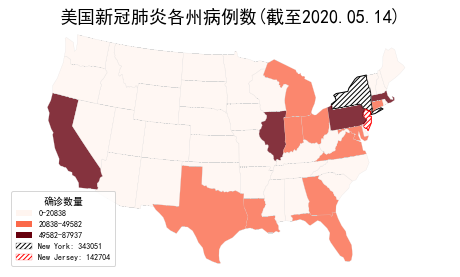

In [6]:
# 图层1：除最严重两州之外的其他州
ax = gplt.choropleth(df=usa_plot_base.query("state not in ['New York', 'New Jersey']"),
                     projection=gcrs.AlbersEqualArea(),
                     hue='Confirmed',
                     scheme=mc.FisherJenks(usa_plot_base.query("state not in ['New York', 'New Jersey']")['Confirmed'], k=3),
                     cmap='Reds',
                     alpha=0.8,
                     edgecolor='lightgrey',
                     linewidth=0.2,
                     figsize=(8, 8)
                     )

# 图层2：纽约州
ax = gplt.polyplot(df=usa_plot_base.query("state == 'New York'"),
                   hatch='/////',
                   edgecolor='black',
                   ax=ax)

# 图层3：新泽西州
ax = gplt.polyplot(df=usa_plot_base.query("state == 'New Jersey'"),
                   hatch='/////',
                   edgecolor='red',
                   extent=usa_plot_base.total_bounds,
                   ax=ax)

# 实例化cmap方案
cmap = plt.get_cmap('Reds')

# 得到mapclassify中BoxPlot的数据分层点
bp = mc.FisherJenks(usa_plot_base.query("state not in ['New York', 'New Jersey']")['Confirmed'], k=3)
bins = [0] + bp.bins.tolist()

# 制作图例映射对象列表，这里分配Greys方案到三种色彩时对应的是[0, 0.5, 1]这三个采样点
LegendElement = [mpatches.Patch(facecolor=cmap(_ / 2), label=f'{int(bins[_])}-{int(bins[_+1])}') 
                 for _ in range(3)] + \
                [mpatches.Patch(facecolor='none', 
                                edgecolor='black', 
                                linewidth=0.2,
                                hatch='/////', 
                                label='New York: {}'.format(usa_plot_base.query("state == \"New York\"").Confirmed.to_list()[0])),
                 mpatches.Patch(facecolor='none', 
                                edgecolor='red', 
                                linewidth=0.2,
                                hatch='/////', 
                                label='New Jersey: {}'.format(usa_plot_base.query("state == \"New Jersey\"").Confirmed.to_list()[0]))]

# 将制作好的图例映射对象列表导入legend()中，并配置相关参数
ax.legend(handles = LegendElement, 
          loc='lower left', 
          fontsize=8, 
          title='确诊数量', 
          title_fontsize=10, 
          borderpad=0.6)

# 添加标题
plt.title('美国新冠肺炎各州病例数(截至2020.05.14)', fontsize=18)

# 保存图像
plt.savefig('图4.png', dpi=300, pad_inches=0, bbox_inches='tight')

## 2.2 Kdeplot

In [7]:
# 读入纽约行政区域面文件
nyc_boroughs = gpd.read_file('geometry/nyc-boroughs.geojson')

# 读入纽约车祸记录点文件
nyc_collision_factors = gpd.read_file('geometry/nyc-collision-factors.geojson')

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


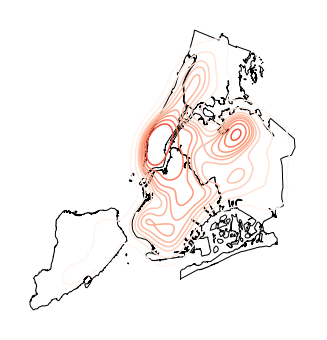

In [8]:
# 图层1：行政边界
ax = gplt.polyplot(df=nyc_boroughs,
                   projection=gcrs.AlbersEqualArea())

# 图层2：默认参数下的kdeplot
ax = gplt.kdeplot(df=nyc_collision_factors,
                  cmap='Reds',
                  ax=ax,
                  figsize=(8, 8))

# 保存图像
plt.savefig('图5.png', dpi=300, pad_inches=0, bbox_inches='tight')

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


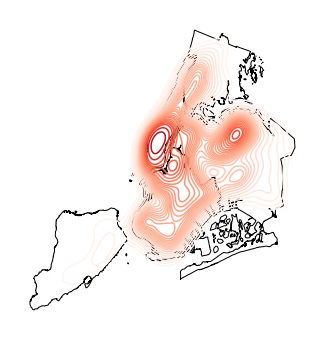

In [9]:
# 图层1：行政边界
ax = gplt.polyplot(df=nyc_boroughs,
                   projection=gcrs.AlbersEqualArea())

# 图层2：kdeplot
ax = gplt.kdeplot(df=nyc_collision_factors,
                  cmap='Reds',
                  n_levels=30,
                  ax=ax,
                  figsize=(8, 8))

# 保存图像
plt.savefig('图6.png', dpi=300, pad_inches=0, bbox_inches='tight')

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


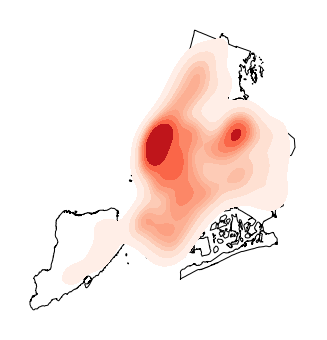

In [10]:
# 图层1：行政边界
ax = gplt.polyplot(df=nyc_boroughs,
                   projection=gcrs.AlbersEqualArea())

# 图层2：kdeplot
ax = gplt.kdeplot(df=nyc_collision_factors,
                  cmap='Reds',
                  shade=True,
                  ax=ax,
                  figsize=(8, 8))

# 保存图像
plt.savefig('图7.png', dpi=300, pad_inches=0, bbox_inches='tight')

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


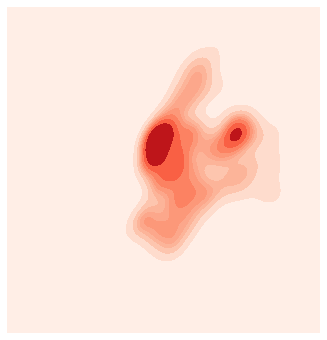

In [11]:
# 图层1：行政边界
ax = gplt.polyplot(df=nyc_boroughs,
                   projection=gcrs.AlbersEqualArea())

# 图层2：kdeplot
ax = gplt.kdeplot(df=nyc_collision_factors,
                  cmap='Reds',
                  shade=True,
                  shade_lowest=True,
                  ax=ax,
                  figsize=(8, 8))

# 保存图像
plt.savefig('图8.png', dpi=300, pad_inches=0, bbox_inches='tight')

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
D:\miniconda3\lib\site-packages\seaborn\distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


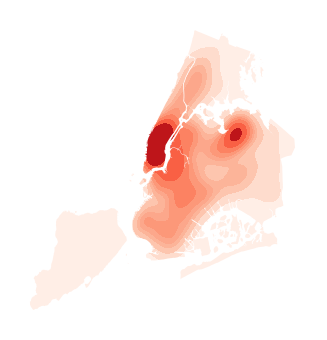

In [12]:
# 图层1：行政边界
ax = gplt.polyplot(df=nyc_boroughs,
                   projection=gcrs.AlbersEqualArea())

# 图层2：kdeplot
ax = gplt.kdeplot(df=nyc_collision_factors,
                  cmap='Reds',
                  shade=True,
                  shade_lowest=True,
                  clip=nyc_boroughs,
                  ax=ax,
                  figsize=(8, 8))

# 保存图像
plt.savefig('图9.png', dpi=300, pad_inches=0, bbox_inches='tight')

## 2.3 Sankey

In [13]:
dc_roads = gpd.read_file('geometry/dc-roads.geojson')
dc_roads.head()

,id,aadt,geometry
0,0,20094,"LINESTRING (-76.98344 38.90013, -76.98330 38.9..."
1,1,1740,"MULTILINESTRING ((-76.99621 38.92511, -76.9962..."
2,2,2000,"LINESTRING (-76.98367 38.86053, -76.98367 38.8..."
3,3,2000,"LINESTRING (-76.99373 38.84623, -76.99323 38.8..."
4,4,2000,"LINESTRING (-77.01948 38.88700, -77.01943 38.8..."


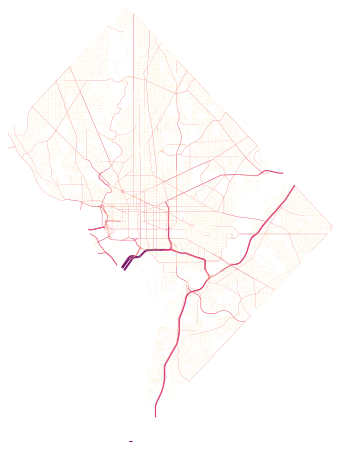

In [14]:
# 选择配色方案为SunsetDark_5
from palettable.cartocolors.sequential import SunsetDark_5

gplt.sankey(
    dc_roads, 
    projection=gcrs.AlbersEqualArea(),
    scale='aadt', 
    hue='aadt',
    limits=(0.1, 2), # 控制线宽范围
    scheme=mc.NaturalBreaks(dc_roads['aadt']),
    cmap=SunsetDark_5.mpl_colormap,
    figsize=(8, 8),
    extent=dc_roads.total_bounds
)

plt.savefig("图11.png", dpi=500, pad_inches=0, bbox_inches='tight')

## 2.5 在模仿中学习

D:\miniconda3\lib\site-packages\geoplot\geoplot.py:903: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:
D:\miniconda3\lib\site-packages\mapclassify\classifiers.py:238: UserWarning: Warning: Not enough unique values in array to form k classes
  Warn(
D:\miniconda3\lib\site-packages\mapclassify\classifiers.py:241: UserWarning: Warning: setting k to 5
  Warn("Warning: setting k to %d" % k_q, UserWarning)
D:\miniconda3\lib\site-packages\geoplot\geoplot.py:623: UserWarning: Cannot set "figsize" when passing an "ax" to the plot. To remove this warning omit the "figsize" parameter.
  warnings.warn(
D:\miniconda3\lib\site-packages\geoplot\geoplot.py:1514: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts o

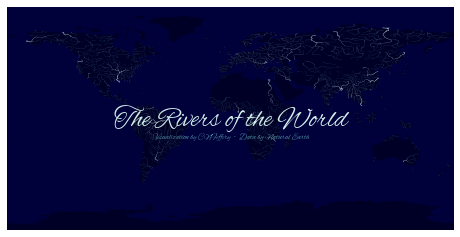

In [16]:
from palettable.cartocolors.sequential import Teal_7_r
import matplotlib.font_manager as fm
from shapely.geometry import box

# 读入世界主要河流线数据
world_river = gpd.read_file('geometry/world_rivers_dSe.geojson')
# 读入世界海洋面数据
world_ocean = gpd.read_file('geometry/world_ocean.shp')

# 图层1：世界范围背景色，基于shapely.geometry中的bbox来生成矩形矢量
ax = gplt.polyplot(df=gpd.GeoDataFrame({'geometry': [box(-180, -90, 180, 90)]}),
                   facecolor='#000026',
                   edgecolor='#000026')

# 图层2：世界海洋面图层
ax = gplt.polyplot(world_ocean,
                   facecolor='#00003a',
                   edgecolor='#00003a',
                   ax=ax)

# 图层3：世界主要河流线图层
ax = gplt.sankey(world_river,
                 scale='StrokeWeig',
                 hue='StrokeWeig',
                 scheme=mc.Quantiles(world_river['StrokeWeig'], 7),
                 cmap=Teal_7_r.mpl_colormap,
                 limits=(0.05, 0.4),
                 figsize=(8, 8),
                 extent=(-180, -90, 180, 90),
                 ax=ax)

# 添加标题
ax.text(0, 0, 'The Rivers of the World', 
        fontproperties=fm.FontProperties(fname="AlexBrush-Regular.ttf"), # 传入Alex Brush手写字体文件
        fontsize=28, 
        color=Teal_7_r.mpl_colors[-1],
        horizontalalignment='center',
        verticalalignment='center')

# 添加作者信息及数据来源
ax.text(0, -15, 'Visualization by CNFeffery  -  Data by Natural Earth', 
        fontproperties=fm.FontProperties(fname="AlexBrush-Regular.ttf"), 
        fontsize=8, 
        color='#599bae',
        horizontalalignment='center',
        verticalalignment='center')

plt.savefig('图13.png', dpi=600, pad_inches=0, bbox_inches='tight')